# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [167]:
DATASET = 'MNIST'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [168]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [169]:
# print available models
model_names = []
for i in (base / 'experiments' / DATASET / 'saved-models').iterdir():
    if i.name[:len(DATASET)] == DATASET:
        model_names.append(i.name.replace(DATASET + '_', ''))
        

model_names.sort(key=lambda x: int(x.split('-')[-1]))
for i, m in enumerate(model_names):
    print(i, m)

0 SGD-32-5
1 SGD-32-30
2 SGD-32-60
3 SGD-32-100
4 SGD-32-150


In [170]:
POSTFIX = model_names[1]
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

FILENAME_POSTFIX

'MNIST_SGD-32-30'

In [171]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastprogress import progress_bar

import torch

from utilities.utils import load_json, load_pickle, get_dataset, get_dataLoader
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Paths

In [173]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_scaler_pca']

# Seed

In [174]:
np.random.seed(SEED)

# Import Data

In [175]:
# import Data
df_train = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_train.csv")
df_test = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_test.csv")
df_eval = pd.read_csv(path_lhl_raw / f"{FILENAME_POSTFIX}_raw_evaluation.csv")

# select only true classified
# df_true = df_train.copy()
df_true = pd.concat([df_train[df_train["true"] == True].copy(), df_test[df_test["true"] == True].copy()])
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

# df_true = df_train[df_train["true"] == True].copy()
# df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_train.shape, df_test.shape, df_eval.shape, df_true.shape 

((60000, 32), (9984, 32), (1000, 32), (67897, 31))

In [176]:
gte_mean = load_json(path_lhl / "neurons_scaler_pca_gte_mean.json")
top_third = load_json(path_lhl / "neurons_scaler_pca_top_third.json")

# Build BDD

In [177]:
# each set of data has its own threshold
thld_p = 0.5
eta = 0
neurons = []
# neurons = gte_mean
# neurons = top_third

# calculate threshold
thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)
# thld1 = np.quantile( df_true.drop('y', axis=1), 0.2, axis=0)
# thld2 = np.quantile( df_true.drop('y', axis=1), 0.5, axis=0)
# thld3 = np.quantile( df_true.drop('y', axis=1), 0.8, axis=0)

# from optuna
# thld = np.array([ -1.19185404,  12.79635195,  -1.19906112,  12.44929473,
#         14.64725433,  16.80028532, -17.45800917,   5.73160821,
#         10.08039263,   6.48782773,  10.87014872,   4.84882803,
#          0.37214349,   6.31361585, -13.87735332,  22.05217285,
#         16.80681332,  -6.50966644,   1.86243299,   0.04027561,
#         20.89539847,  -8.8872976 ,  -4.9736362 ,  10.8866549 ,
#          2.08586646,  -0.49341795,  -6.21431094,  27.19567785,
#         -7.96599741,   1.35437002])

# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons)
df_train_copy, df_test_copy, df_eval_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy(), df_eval.copy()] )


# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)
df_eval_scores = patterns.score_dataframe_multi_eta(df_eval_copy, eta)

# add metadata
# patterns.stats['thld'] = f'qth_{thld_p}'
patterns.stats['thld'] = f'optuna-30'
patterns.stats['num_observations'] = df_true.shape[0]

In [178]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,num_observations
1,optuna-30,0.0,2.4,4308.905,0.0,67897.0,38.7,0.0,30.0,2023-08-06 00:13:27,2023-08-06 00:13:28,67897


In [179]:
df_train_scores.loc[ df_train_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
10,all,60000.0,1368.0,1368.0,0.0,0.0228,1.0,0.0,0


In [180]:
df_test_scores.loc[ df_test_scores['y'] == 'all']

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
10,all,9984.0,216.0,216.0,0.0,0.021635,1.0,0.0,0


In [181]:
df_eval_scores.loc[ df_eval_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
1,all,1000.0,906.0,0.0,906.0,0.906,1.0,0.0,0


## Full Evaluation data

In [159]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA
from models.cifar10_model import Cifar10_CNN

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
#     'cifar10': Cifar10_DLA,
    'cifar10': Cifar10_CNN
}


targets_datasets = {
    'MNIST': 'FashionMNIST',
    'FashionMNIST': 'MNIST',
    'GTSRB': 'Cifar10',
}

In [160]:
# load sacler object
sacler_ = load_pickle(path_lhl / f'scaler.pkl')
# load pca object
pca_ = load_pickle(path_lhl / f'scaler_pca.pkl')

In [161]:
TARGET_DATASET = targets_datasets[DATASET]
path_target_data = paths['data'].parent / TARGET_DATASET


# load config file
configs = load_json(paths['configuration'])
# model config
model_setup = configs['model_setup']
# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

# load trained model
model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]['train']

test_data = get_dataset(TARGET_DATASET, path_target_data, train=False, transform=transformer)
testloader = get_dataLoader(test_data)

In [162]:
N = int(POSTFIX.split('-')[-1])
BS = testloader.batch_size


model_setup['last_hidden_neurons'] = N
model = model_(**model_setup)
model = torch.compile(model)


# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

# get last hidden layer logits for target data
logits = np.zeros((BS * len(testloader), N), dtype=np.float64)

for i, (x, _) in enumerate(testloader):
    logits_target, _ = model.output_last_layer(x)
    logits[BS*i:(i+1)*BS] = logits_target.numpy()
    
logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])
logits['y'] = 1
logits['true'] = 1

# # transform data
# logits_target = applyPCASingle(logits_target, sacler_, pca_, N)

In [163]:
logits_copy = logits.copy()
patterns.evaluate_dataframe(logits_copy, 0)

In [164]:
logits_copy.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,y,true,bdd_0
0,0.003632,0.182130,0.129657,0.114626,-1.465341,0.468010,0.349984,0.574371,0.741739,-0.587210,...,0.412588,-0.404800,1.110941,1.041918,-0.334109,-0.228985,-0.253282,1,1,0
1,-0.963079,0.312556,0.980052,0.453017,-0.139957,0.145112,0.546575,-0.017699,-0.080211,-0.190439,...,-0.596707,-0.346958,0.328312,0.521455,0.695181,-0.312496,-1.017301,1,1,0
2,-0.402968,0.203526,0.131765,-0.099070,-0.531941,0.455495,0.758335,0.369431,0.578867,-0.378273,...,-0.288610,0.084457,0.021671,0.185394,0.265477,-0.586579,-0.164806,1,1,0
3,0.295552,-0.174304,0.224718,-0.068794,-0.351254,-0.320608,-0.028574,-0.353354,-0.013269,-0.826952,...,-0.149710,0.012287,0.759326,0.097537,0.185930,-0.409140,0.036795,1,1,0
4,0.103591,-0.187605,-0.165391,-0.164101,-0.979601,0.399708,0.905554,0.465895,1.342914,-0.805566,...,0.518080,-0.627676,1.611081,0.445392,-0.055380,0.013853,-0.236062,1,1,0


In [165]:
logits_scores = patterns.score_dataframe(logits_copy, 'bdd_0')

In [166]:
logits_scores

,count,bdd_0_false,bdd_0_false_misclassified,bdd_0_false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified
y,,,,,,,
1,9984.0,9361.0,0.0,9361.0,0.9376,1.0000,0.0
all,9984.0,9361.0,0.0,9361.0,0.9376,1.0000,0.0
all_mean,9984.0,9361.0,0.0,0.0,0.0000,0.9376,0.0


## Manual Test

In [15]:
df_patterns = (df_true.drop('y', axis=1) >= thld).astype(np.int8)

In [16]:
n = 100
# df_test_patterns = (df_test.drop(['true','y'], axis=1).sample(n) >= thld).astype(np.int8)
df_test_patterns = (df_test.drop(['true','y'], axis=1) >= thld).astype(np.int8)

In [17]:
df_test_patterns.apply(lambda x: x.values in df_patterns.values, axis=1).sum()

4192

## Manual BDD

In [18]:
from dd import cudd
import time

memory=1_000
bdd = cudd.BDD(memory_estimate= memory * 2**30)
root = bdd.false

In [19]:
num_bits = 1
vars_range = range(df_patterns.shape[1])
vars = [f'x{n}_{i}' for i in range(num_bits) for n in vars_range]

In [20]:
for v in vars:
    bdd.add_var(v)

vars = np.array([ *map(bdd.var, vars) ])
vars_not = np.array([ ~v for v in vars ])

In [21]:
# print(
#     vars_not[0],
#     vars[1],
# )
# print(df_patterns.iloc[0, :2])
# np.where(df_patterns.iloc[0, :], vars, vars_not)[:2]

In [22]:
construct_pattern = lambda row: np.bitwise_and.reduce( np.where(row, vars, vars_not) )
test_pattern = lambda row: (root & construct_pattern(row) ) == bdd.false

In [23]:
t_start = time.perf_counter()

results = np.zeros((df_patterns.shape[0] // 1000) + 1)

for i, row in df_patterns.iterrows():
    root |= construct_pattern( row )
    if i % 1000 == 0:
        results[i // 1000] = np.apply_along_axis(test_pattern, 1, df_test_patterns.to_numpy()).sum()
        
results[-1] = np.apply_along_axis(test_pattern, 1, df_test_patterns.to_numpy()).sum()

t_end = time.perf_counter()
f"Finished in {round((t_end - t_start),3)} seconds."

'Finished in 69.874 seconds.'

<Axes: >

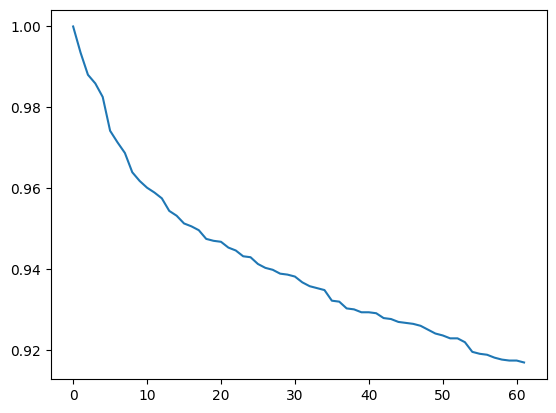

In [26]:
sns.lineplot(x=range(results.shape[0]), y=results / df_test_patterns.shape[0])
# plt.ylim(0)

## Test vs Train

In [27]:
# each set of data has its own threshold
thld_p = 0.5
eta = 0
neurons = []
# neurons = gte_mean
# neurons = top_third


df_true = df_test[df_test["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)


# calculate threshold
thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)


# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons)
df_train_copy, df_test_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy()] )


# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)


# add metadata
patterns.stats['thld'] = f'qth_{thld_p}'
patterns.stats['num_observations'] = df_true.shape[0]

In [28]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,num_observations
1,qth_0.5,0.0,0.7,4310.014,0.0,4038.0,72.4,0.0,50.0,2023-08-03 10:51:29,2023-08-03 10:51:30,4038


In [29]:
df_train_scores.loc[ df_train_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
43,all,63968.0,62691.0,2344.0,60347.0,0.980037,0.03739,0.96261,0


In [30]:
df_test_scores.loc[ df_test_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
43,all,4192.0,154.0,154.0,0.0,0.036737,1.0,0.0,0


## Merge then sample Test

In [40]:
from sklearn.model_selection import train_test_split

# each set of data has its own threshold
thld_p = 0.5
eta = 0
neurons = []
# neurons = gte_mean
# neurons = top_third

df_train = pd.concat([df_train, df_test])
df_train, df_test = train_test_split(df_train, test_size=0.2, shuffle=True, stratify=df_train['y'])

# df_train = pd.concat([df_train, df_test])
# df_test = df_train.sample(int(df_train.shape[0] * 0.2))


df_true = df_train[df_train["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)


# calculate threshold
thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)


# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons)
df_train_copy, df_test_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy()] )


# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)


# add metadata
patterns.stats['thld'] = f'qth_{thld_p}'
patterns.stats['num_observations'] = df_true.shape[0]

In [41]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,num_observations
1,qth_0.5,0.0,12.4,4341.121,0.0,52527.0,63.8,0.0,50.0,2023-08-03 10:58:00,2023-08-03 10:58:08,52527


In [42]:
df_train_scores.loc[ df_train_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
43,all,54528.0,1998.0,1998.0,0.0,0.036642,1.0,0.0,0


In [43]:
df_test_scores.loc[ df_test_scores['y'] == 'all' ]

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
43,all,13632.0,6674.0,498.0,6176.0,0.489583,0.074618,0.925382,0
